<a href="https://colab.research.google.com/github/wellecks/transformers4math-simons/blob/main/4_graphs/graphs_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part 4: Applications | Triangle-Free Graphs

**Tutorial on Transformers for Mathematics**

*Simons Institute and SLMath Joint Workshop: AI for Mathematics and Theoretical Computer Science, April 8 2025*

Author: Sean Welleck

------

This notebook trains a transformer language model on a dataset using the [makemore]() library as a black box.

Then we generate outputs with the language model and evaluate the outputs.

The task is **finding a triangle-free graph on n-vertices with the maximal number of edges** as described in the tutorial talk.

------


In [ ]:
# Download files
!mkdir out
!wget https://raw.githubusercontent.com/wellecks/transformers4math-simons/refs/heads/main/4_graphs/graph_utils.py -O graph_utils.py
!wget https://raw.githubusercontent.com/wellecks/transformers4math-simons/refs/heads/main/4_graphs/local_search.py -O local_search.py
!wget https://raw.githubusercontent.com/wellecks/transformers4math-simons/refs/heads/main/4_graphs/makemore.py -O makemore.py
!wget https://github.com/wellecks/transformers4math-simons/raw/refs/heads/main/4_graphs/out/model_top10_provided.pt -O out/model_top10_provided.pt

#### Dataset

First run local search to get the dataset

In [ ]:
!python local_search.py

In [3]:
dataset = "data/top_10_percent_graphs.txt"

!head -n 5 $dataset

0010000011000100101,110001100110100001,01110010001010110,1110000001010010,001101010001001,01101010100001,1101010100001,010001010110,10001010110,0010001000,100000010,01011000,1010110,100001,11000,0001,110,00,1
0000001001101110000,011010000001100101,00001001101110000,0101111100001010,101101100011010,10000011000101,1111100001010,000010000101,00001100101,0001110100,010000101,10000101,0110000,001010,01010,0001,101,10,1
0101001110101010000,101001110101000110,00100001010101001,0101001010011000,110001010100001,00110101000110,1000101001100,000000100001,01010101001,1010101001,101000110,10100001,1000110,100001,00110,0110,010,01,1
1110101011000110001,001000000111000110,00000100111000110,0000100111000110,000101000110001,10100110000110,0000001111000,100111000110,10000001000,0111000110,111000110,00111000,0110001,000001,00110,0110,101,00,1
0011000010011110001,011000110011010001,11000001011100000,0110000000001110,011000100001110,01010101110001,0110011010001,100010000000,01100100010,1000001110,000010001

### Train a transformer language model on the dataset

On Colab, please select go to `Runtime -> Change runtime type -> T4 GPU` to run this on a GPU. You'll need to re-run the cells up to this point. You can also run on CPU by removing --device cuda in the commands below.

In [ ]:
!python makemore.py -i $dataset --n-layer 4 --n-head 4 --n-embd 64 --n-embd2 64 --max-steps 50000 --device cuda

### Generate graphs

In [ ]:
import makemore
import torch

def load(filename='out/model_top10_provided.pt', dataset='data/top_10_percent_graphs.txt', n_layer=4, n_head=4, n_embd=64, n_embd2=64):
    train_dataset, test_dataset = makemore.create_datasets(dataset)
    vocab_size = train_dataset.get_vocab_size()
    block_size = train_dataset.get_output_length()

    config = makemore.ModelConfig(
        vocab_size=vocab_size, block_size=block_size,
        n_layer=n_layer, n_head=n_head,
        n_embd=n_embd, n_embd2=n_embd2
    )
    model = makemore.Transformer(config)
    model.load_state_dict(torch.load(filename, map_location=torch.device('cpu')))
    return train_dataset, test_dataset, model

In [ ]:
import graph_utils
num_samples = 1000
device = 'cpu'

train_dataset, test_dataset, model = load()

# Generate many samples
all_samples, new_samples = graph_utils.batch_generate(model, train_dataset, num=num_samples, device=device)
# Evaluate the samples
scores = []
for sample in all_samples:
    adj_matrix = graph_utils.deserialize_graph(sample)
    if adj_matrix is not None:
        score = graph_utils.evaluate_graph(adj_matrix)
        scores.append(score)

number of examples in the dataset: 13147
max word length: 208
number of unique characters in the vocabulary: 3
vocabulary:
,01
split up the dataset into 12147 training examples and 1000 test examples
number of parameters: 0.21M


100%|██████████| 62/62 [04:56<00:00,  4.78s/it]


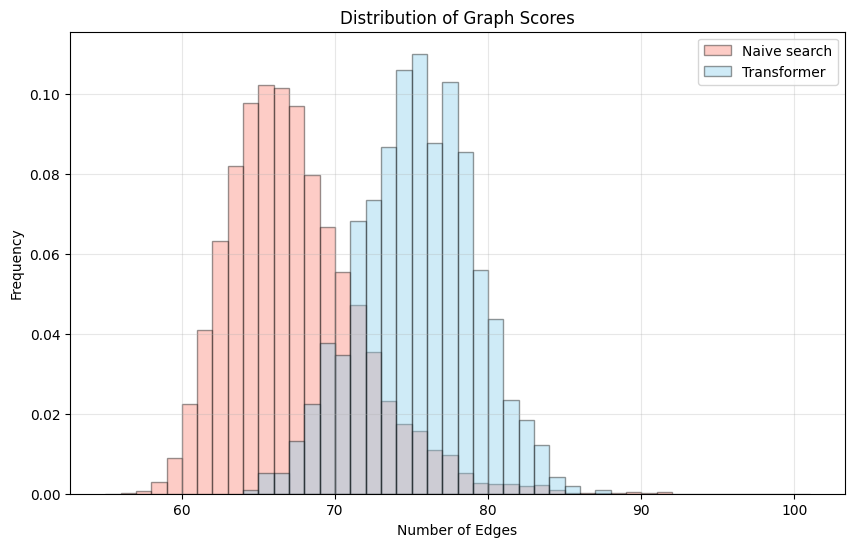

In [ ]:
import matplotlib.pyplot as plt

# Read all graphs dataset
with open('data/all_graphs.txt', 'r') as f:
    serialized_graphs = [line.strip() for line in f]

# Deserialize and evaluate each graph
data_scores = []
for graph_str in serialized_graphs:
    adj_matrix = graph_utils.deserialize_graph(graph_str)
    if adj_matrix is None:
        continue
    score = graph_utils.evaluate_graph(adj_matrix)
    data_scores.append(score)

# Plot distribution of both sets of scores
plt.figure(figsize=(10, 6))
plt.hist(data_scores, bins=range(int(min(data_scores)), int(max(data_scores)) + 2), alpha=0.4, density=True, color='salmon', label='Naive search', edgecolor='black')
plt.hist(scores, bins=range(int(min(scores)), int(max(scores)) + 2), alpha=0.4, density=True, color='skyblue', label='Transformer', edgecolor='black')

plt.xlabel('Number of Edges')
plt.ylabel('Frequency')
plt.title('Distribution of Graph Scores')
plt.grid(alpha=0.3)
plt.legend()